<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Editing-MNIST-example-to-use-COCO-data" data-toc-modified-id="Editing-MNIST-example-to-use-COCO-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Editing MNIST example to use COCO data</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Original-COCO-ETL" data-toc-modified-id="Original-COCO-ETL-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Original COCO ETL</a></span></li><li><span><a href="#Grab-subset-of-COCO-ims-&amp;-create-dataloader" data-toc-modified-id="Grab-subset-of-COCO-ims-&amp;-create-dataloader-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Grab subset of COCO ims &amp; create dataloader</a></span></li><li><span><a href="#Showing-images" data-toc-modified-id="Showing-images-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Showing images</a></span></li></ul></li><li><span><a href="#Model-&amp;-Training" data-toc-modified-id="Model-&amp;-Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model &amp; Training</a></span></li><li><span><a href="#Train-model-once-w/-train_n_epochs" data-toc-modified-id="Train-model-once-w/-train_n_epochs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train model once w/ <code>train_n_epochs</code></a></span></li><li><span><a href="#Train-model-many-times-w/-train_n_sessions" data-toc-modified-id="Train-model-many-times-w/-train_n_sessions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Train model many times w/ <code>train_n_sessions</code></a></span></li></ul></li></ul></div>

# Editing MNIST example to use COCO data

## Data

### Original COCO ETL

In [ ]:
from fastai.vision.all import *
from fastcore.test import *
import pandas as pd
import numpy as np
import PIL


### Unzip data ###
path = Path('/home/rory/data/coco2017')
path_items = path.ls()
from zipfile import ZipFile
def unzip(*paths,dest):
    """Unzips files located at posixpaths to dest. Deps: zipfile, pathlib."""
    for path in paths:
        if path.suffix == '.zip':
            print(f"Unzipping: {path} ---> {dest}.")
            with ZipFile(path, 'r') as archive:
                archive.extractall(dest)
    new_items = set(dest.ls()) - set(paths)
    print("Finished. New items in dest:",*new_items,sep='\n')
# unzip(*path_items, dest=path)


### Get ims and annos ###
ims_train, annos_train = get_annotations(path/'annotations/instances_train2017.json')
ims_valid, annos_valid = get_annotations(path/'annotations/instances_val2017.json')
ims_train = list(map(lambda x: Path('train2017/' + x), ims_train))
ims_valid = list(map(lambda x: Path('val2017/' + x), ims_valid))
ims    = ims_train + ims_valid
paths  = list(map(lambda im: Path(path/im), ims))
annos  = annos_train + annos_valid
bboxes = [i[0] for i in annos]
lbls   = [i[1] for i in annos]


### Process annos ###
def transpose(l): return list(zip(*l))
def bbox_area(anno_t): # takes a transposed anno
    b = anno_t[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = [sort_annos(a) for a in annos]
largest_anno = [i[0] for i in sorted_annos]
largest_bbox = [i[0] for i in largest_anno]
largest_lbl  = [i[1] for i in largest_anno]
is_valid     = [False]*len(ims_train) + [True]*len(ims_valid)


### Store outputs in dfd, df ###
dfd_all = {
    "im":ims,
    "path":paths,
    "annos":annos,
    "bboxes":bboxes,
    "lbls":lbls,
    "sorted_annos":sorted_annos,
    "anno":largest_anno,
    "bbox":largest_bbox,
    "lbl":largest_lbl,
    "is_valid":is_valid}
df_all = pd.DataFrame(dfd_all)

### Grab subset of COCO ims & create dataloader

Create subset and throw it in a dl.

In [ ]:
### Init data ###
### Grab data & grab singletons ###
data = L(zip(paths, largest_lbl))
num_labels = L(len(l) for l in lbls)
singletons = data[num_labels.map(lambda n:n==1)]

### Given a lbl, grab all paths with that label ###
path2lbl = {p:l for p,l in singletons}
def get_lbl(path): return path2lbl[path]
transposed = list(zip(*singletons))
lbl2paths = {l:[p for p in transposed[0] if get_lbl(p) == l]
             for l in set(transposed[1])}

### Grab labels with more than 500 singleton ims ###
lbl_subset = []
for lbl in lbl2paths:
    l = len(lbl2paths[lbl])
    if l > 500: lbl_subset += [lbl]

### Grab ims in label_subset ###
data_subset = L(s for s in singletons if s[1] in lbl_subset)

### Convert to tensors ###
# paths to tensors
def open_im(imp, size=128):
    im = PIL.Image.open(imp).convert('RGB')
    im = im.resize((size, size))
    t = torch.Tensor(np.array(im))
    t = t.permute(2,0,1).float()/255.0
    return t.reshape([3*size*size])
# lbls to tensors
n_cls = len(lbl_subset)
encs = []
for i in range(n_cls):
    l = L([0]*n_cls)
    l[i] = 1
    encs += [l]
lie = list(zip(lbl_subset, range(n_cls), tensor(encs)))
lbl2enc = {l:e for l,i,e in lie}
idx2lbl = {i:l for l,i,e in lie}
encrepr2lbl = {repr(tensor(e)):l for l,i,e in lie}
# convert and create dl
ds = [(open_im(path), lbl2enc[lbl]) for path, lbl in data_subset]
dl = DataLoader(ds, batch_size=64, shuffle=True)

## Model & Training

In [ ]:
### Model ###
def init_mod(im_size, n_cls, hidden_params):
    mod = nn.Sequential(
        nn.Linear(im_size,hidden_params),
        nn.ReLU(),
        nn.Linear(hidden_params,n_cls)
    )
    return mod

### Loss ###
def softmax(t):
    if len(t.shape) == 1: return torch.exp(t) / torch.exp(t).sum()
    else:                 return torch.exp(t) / torch.exp(t).sum(dim=1, keepdim=True)    
def loss(yp, y):
    return (1 - (y*softmax(yp)).sum(dim=1, keepdim=True)).mean()  # softmax cross entropy loss

### Calculate gradients for use in train_once ###
def calc_grad(x,y,mod):
    yp = mod(x)     # get predictions
    ls = loss(yp,y) # calculate loss
    ls.backward()   # take gradient w.r.t. loss

### Create SGD Stepper; args = (mod.parameters(), lr) ###
class ParamStepper:
    def __init__(self, p, lr): self.p,self.lr = list(p),lr # initialize w/ mod.params & lr
        
    def step(self, *args, **kwargs):                       # take step
        for o in self.p: o.data -= o.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):                  # reset grad
        for o in self.p: o.grad = None

### Train parameters by performing SGD on each mini-batch in the dl ###
def train_one_epoch(dl, mod, stepper):
    for xb,yb in dl:           # for every minibatch (xb,yb) in the dataloader:
        calc_grad(xb, yb, mod) # calc grad(loss(mod(xb),yb))
        stepper.step()         # take step
        stepper.zero_grad()    # reset grad

### Get accuracy of mod on a mini-batch ###
def mb_acc(yp,y):
    yp_max, yp_i = torch.max(yp, dim=1, keepdim=True)
    y_max,  y_i  = torch.max(y,  dim=1, keepdim=True)
    return (yp_i==y_i).float().mean()
        
### Get accuracy of mod on a dataloader (takes avg of all mbs in dl) ###
def epoch_acc(dl, mod):
    a = [mb_acc(mod(xb), yb) for xb,yb in dl]
    return round(torch.stack(a).mean().item(), 5)          # avg acc over all mini-batches

### Run `train_once` `epochs` times given data `dl`, model `mod`, and stepper `stepper`
def train_n_epochs(dl, mod, stepper, nepochs):
    accs = L()
    for i in range(nepochs):
        train_one_epoch(dl, mod, stepper)
        accs += epoch_acc(dl, mod)
        print(round(epoch_acc(dl, mod),4),end='\t')
    print('',end='\n')
    return accs

### Perform n training sessions ###
def train_n_sessions(dl, im_size, n_cls, hidden_params, nepochs, lr, nsessions):
    # accuracies and trained models are returned by train_n_sessions for access after training.
    accs = L()
    mods = L()
    # train model and record accs, mods
    print('Progress:',end='\n')
    for i in range(nsessions):
        print('Session',i,end='\n')
        mod = init_mod(im_size, n_cls, hidden_params)
        stepper = ParamStepper(mod.parameters(), lr)
        accs += train_n_epochs(dl, mod, stepper, nepochs)
        mods += mod
    # restructure mods into nn.Sequential form for end-user convenience
    nmods = len(mods)
    trained_models = L()
    for n in range(nsessions):
        layers = L()
        for j in range(nmods//nsessions): layers.append(mods.pop())
        layers.reverse()
        seqmod = nn.Sequential(*layers.items)
        trained_models += [seqmod]
    print('Done')
    return accs, trained_models

### Visualize ###
def show_im(im, lbl=None, ctx=None):
    """Takes im tensor and lbl tensor, shows image, returns axes object."""
    if isinstance(im, torch.Tensor):  im = im.reshape(3,128,128)
    if isinstance(im, Path):          im = PILImage.create(im)
    if lbl == None: return show_image(im, ctx=ctx)
    if isinstance(lbl, torch.Tensor): lbl = encrepr2lbl[repr(lbl)]
    return show_image(im, title=lbl, ctx=ctx)
def show_b(b, n=10, nrows=2, ncols=5):
    """Takes dl or batch and shows grid of images."""
    if isinstance(b, DataLoader):
        b = list(b)[0]
    ims, lbls = b
    sz = min(n, ims.shape[0])
    ctxs = get_grid(sz, nrows, ncols)
    for i,ctx in enumerate(ctxs):
        show_im(ims[i], lbls[i], ctx=ctx)
def show_pred(mod, xy, ctx=None):
    x,y = xy
    yp = mod(x)
    yp_max, yp_i = torch.max(yp, dim=0, keepdim=True)
    y_max,  y_i  = torch.max(y,  dim=0, keepdim=True)
    title = f"{str((yp_i==y_i).item())[0]} | {idx2lbl[y_i.item()]} | {idx2lbl[yp_i.item()]}"
    return show_im(x,title,ctx=ctx)
def show_preds(mod, ds, n=10, nrows=2, ncols=5):
    ctxs = get_grid(n, nrows, ncols)
    for i,ctx in enumerate(ctxs):
        show_pred(mod, ds[i], ctx=ctx)

## Train model once w/ `train_n_epochs`

In [ ]:
# params
im_size       = 128*128*3
n_cls         = len(lbl_subset)
batch_size    = 64
hidden_params = 30
lr            = .005
nepochs       = 100
nsessions     = 4

# inits
mod           = init_mod(im_size, n_cls, hidden_params)
stepper       = ParamStepper(mod.parameters(), lr)

# train
accs = train_n_epochs(dl, mod, stepper, nepochs)

# view results
print(max(accs))
show_preds(mod, ds);

0.2295	0.3164	0.3189	0.3012	0.3112	0.3361	0.3197	0.3339	0.3235	0.3329	0.3398	0.3358	0.3296	0.343	0.3252	0.3469	0.3306	0.3451	0.3445	0.3493	0.3416	0.3448	0.3518	0.337	0.35	0.3412	0.3487	0.3534	0.3513	0.3394	0.3478	0.3514	0.3533	0.3545	0.3555	0.3477	0.3594	0.3592	0.3501	0.3449	0.3598	0.3662	0.3692	0.3624	0.3533	0.3077	0.3438	0.375	0.3744	0.3696	0.3788	0.3553	0.3668	0.3867	0.3879	0.3705	0.3802	0.3898	0.3874	0.3967	0.3961	0.4012	0.3938	0.3694	0.4029	0.3952	0.4016	0.3973	0.3915	0.4078	0.408	0.4041	0.4035	0.408	0.4096	0.4193	0.4136	0.4065	0.4109	0.4123	0.411	0.4282	0.4142	0.4235	0.4236	0.4348	0.4301	0.4381	0.4405	0.436	0.4062	0.4185	0.4343	0.4427	0.423	0.399	0.3828	0.4384	0.3937	0.4298	
0.44271


## Train model many times w/ `train_n_sessions`

In [ ]:
# params
im_size       = 128*128*3
n_cls         = len(lbl_subset)
batch_size    = 64
hidden_params = 30
lr            = .005
nepochs       = 10
nsessions     = 2

# train
accs, mods = train_n_sessions(dl, im_size, n_cls, hidden_params, nepochs, lr, nsessions)
accs_t = tensor(accs).reshape(nsessions,nepochs)

# view results
print("Max accuracy:",round(accs_t.max().item(),4))
pd.DataFrame(accs_t.numpy())

Progress:
Session 0
0.2176	0.2444	0.2532	0.2338	0.259	0.2623	0.2666	0.2694	0.2778	0.2888	
Session 1
0.2467	0.2433	0.3223	0.3255	0.2925	0.3105	0.3113	0.3246	0.3361	0.3168	
Done
Max accuracy: 0.3351


,0,1,2,3,4,5,6,7,8,9
0,0.21759,0.24436,0.25318,0.23278,0.25391,0.26027,0.26562,0.26939,0.27980,0.28979
1,0.24566,0.24334,0.32031,0.32653,0.29355,0.31351,0.31438,0.32364,0.33507,0.31481


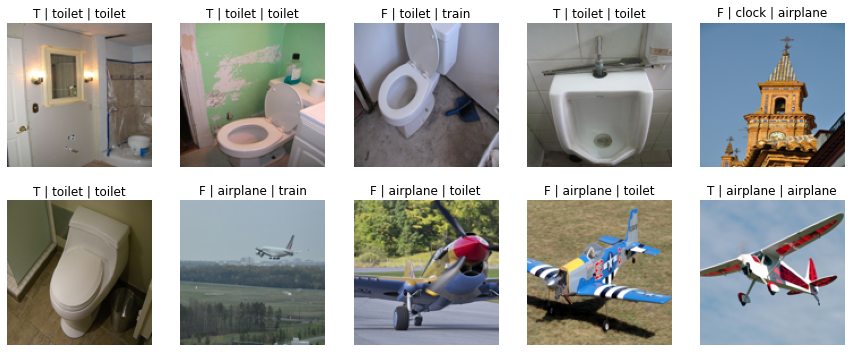

In [ ]:
show_preds(mods[0],ds)